<a href="https://colab.research.google.com/github/yourfriendjacob/js-spring-cs5567/blob/main/cifar10_ccn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score


In [2]:
(X_train, Y_train), (X_test,Y_test) = tf.keras.datasets.cifar10.load_data()

x_train,x_val,y_train,y_val = train_test_split(X_train, Y_train, test_size = 0.2)

y_train = to_categorical(y_train, num_classes = 10)
y_val = to_categorical(y_val, num_classes = 10)
y_test = to_categorical(Y_test, num_classes = 10)

x_train = x_train * 1.0/255

x_val = x_val * 1.0/255

X_test = X_test * 1.0/255

train_datagen = ImageDataGenerator(
        rotation_range = 10,
        zoom_range = 0.1,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        shear_range = 0.1,
        horizontal_flip = True,
        vertical_flip = False
        )
train_datagen.fit(x_train)


170498071/170498071 [==============================] - 13s 0us/step


In [3]:
print(f'x train shape: {x_train.shape}')
print(f'y train shape: {y_train.shape}')

x train shape: (40000, 32, 32, 3)
y train shape: (40000, 10)


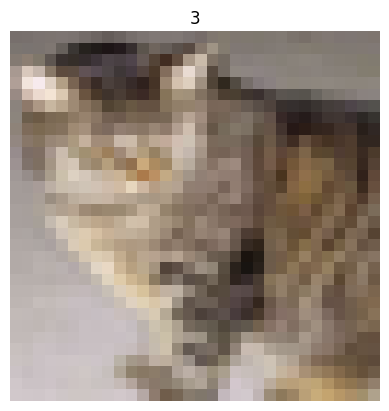

In [4]:
index = 20

test_image = x_train[index]
test_label = np.argmax(y_train[index])
plt.imshow(test_image)
plt.title(test_label)
plt.axis('off')
plt.show()

In [17]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.6,
    min_lr=1e-6)


model = tf.keras.models.Sequential()
model.add(UpSampling2D(size = (2, 2), interpolation='bilinear'))
model.add(Conv2D(filters = 250, kernel_size= (9, 9), activation = 'sigmoid', input_shape = (64, 64, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(filters = 250, kernel_size = (3, 3), activation = 'tanh')) #input 28,28 output 26,26
model.add(MaxPooling2D(2, 2)) #output 13,13
model.add(Conv2D(filters = 250, kernel_size = (4, 4), activation = 'relu')) #output 10,10
model.add(MaxPooling2D(2, 2)) #output 5,5
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(10, activation = 'softmax'))

optimizer = tf.keras.optimizers.SGD(learning_rate=0.004, momentum=.9, nesterov=True)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])



In [31]:
result = model.fit(
    x_train, y_train,
    batch_size = 100,
    validation_data = (x_val, y_val),
    epochs = 20,
    verbose = 1,
    callbacks = [learning_rate_reduction]
)

Epoch 1/20
400/400 [==============================] - 44s 110ms/step - loss: 0.0954 - accuracy: 0.9676 - val_loss: 1.9756 - val_accuracy: 0.6514 - lr: 1.8662e-04
Epoch 2/20
400/400 [==============================] - 45s 113ms/step - loss: 0.0950 - accuracy: 0.9688 - val_loss: 1.9739 - val_accuracy: 0.6525 - lr: 1.8662e-04
Epoch 3/20
400/400 [==============================] - 46s 114ms/step - loss: 0.0895 - accuracy: 0.9702 - val_loss: 1.9725 - val_accuracy: 0.6509 - lr: 1.8662e-04
Epoch 4/20
400/400 [==============================] - 45s 113ms/step - loss: 0.0896 - accuracy: 0.9705 - val_loss: 1.9843 - val_accuracy: 0.6509 - lr: 1.8662e-04
Epoch 5/20
400/400 [==============================] - ETA: 0s - loss: 0.0893 - accuracy: 0.9708
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00011197440326213836.
400/400 [==============================] - 46s 114ms/step - loss: 0.0893 - accuracy: 0.9708 - val_loss: 1.9856 - val_accuracy: 0.6517 - lr: 1.8662e-04
Epoch 6/20
400/400 [========

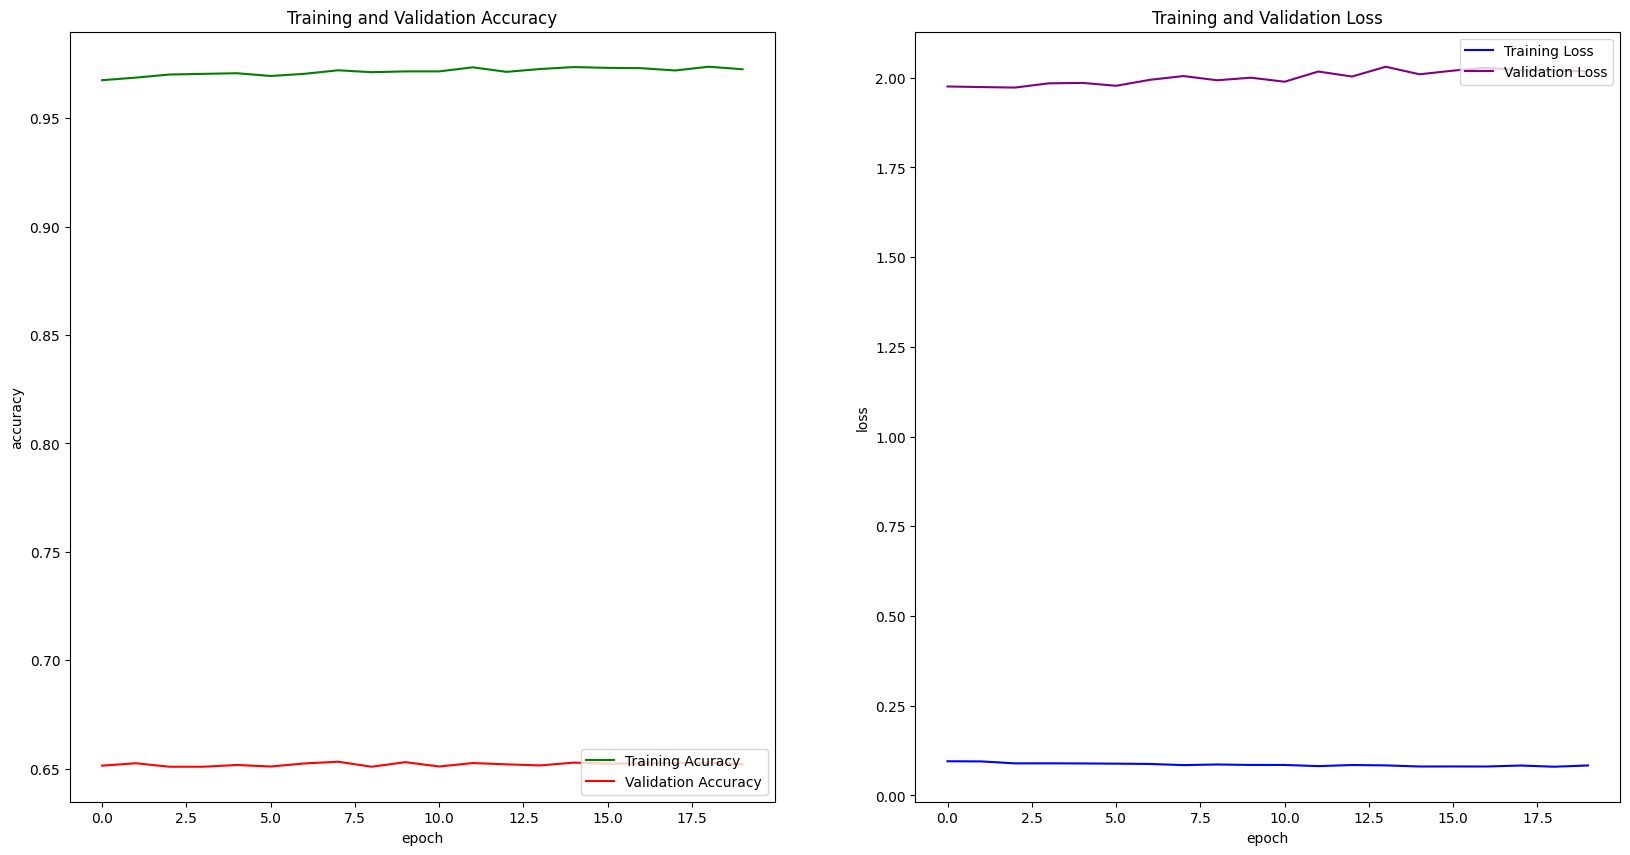

In [32]:
def plot_acc_loss(result):
  # function to plot the accuracy and loss graphs
  acc = result.history['accuracy']
  val_acc = result.history['val_accuracy']
  loss = result.history['loss']
  val_loss = result.history['val_loss']

  plt.figure(figsize=(20, 10))
  plt.subplot(1, 2, 1)
  plt.title("Training and Validation Accuracy")
  plt.plot(acc,color = 'green',label = 'Training Acuracy')
  plt.plot(val_acc,color = 'red',label = 'Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.subplot(1, 2, 2)
  plt.title('Training and Validation Loss')
  plt.plot(loss,color = 'blue',label = 'Training Loss')
  plt.plot(val_loss,color = 'purple',label = 'Validation Loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(loc='upper right')
  plt.show()


plot_acc_loss(result)

In [33]:
y_pred = np.argmax(model.predict(X_test), axis=-1)
y_true = Y_test.ravel()
print(y_pred.shape,y_true.shape, X_test.shape)
print("Testing Accuracy: ", accuracy_score(y_true,y_pred))

313/313 [==============================] - 3s 10ms/step
(10000,) (10000,) (10000, 32, 32, 3)
Testing Accuracy:  0.6562


In [34]:
import pandas as pd
hist_df = pd.DataFrame(result.history)
hist_csv_file = '/a_54.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

model.save('/a_54.keras')